### Simple CNN with Tensorflow

In [1]:
from IPython.display import clear_output
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, callbacks, optimizers
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
import regionmask
clear_output(wait=True)

2023-03-08 13:39:56.137873: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 13:39:57.042629: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-08 13:39:57.042664: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-08 13:40:10.081109: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

### Data preprocessing

In [2]:
delta_SST = xr.open_dataarray("delta_SST_pr.nc").compute()
delta_precip = xr.open_dataarray("delta_precip_10deg.nc").compute()

In [4]:
# choose specific point on 10deg x 10deg precip grid for labels
precip_lat = 5.0
precip_lon = 175.0

First need to mask out land in delta_SST data before putting in neural net!

In [5]:
landmask = np.isnan(regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(delta_SST.lon.values, delta_SST.lat.values))

In [6]:
X = delta_SST.sel(lat=slice(60, -60)).where(landmask).to_numpy()
X = np.nan_to_num(X[..., np.newaxis]) # required third dimension for input to CNN
# X is in range from (-2, 2), so reasonable and no need to feature scale
Y = delta_precip.sel(time_avg='ANNUAL', lat=precip_lat, lon=precip_lon).to_numpy()
Y = Y[..., np.newaxis]
Y.var()

14.15308559349163

In [7]:
Y_scaler = StandardScaler()
Y = Y_scaler.fit_transform(Y)

In [8]:
num_examples = X.shape[0]
print(num_examples)
print(X.shape)
print(Y.shape)

5545
(5545, 97, 192, 1)
(5545, 1)


In [9]:
Y.var()

1.0000000000000002

In [10]:
X_train = X[:int(0.8*num_examples)]
X_test = X[int(0.8*num_examples):]
Y_train = Y[:int(0.8*num_examples)]
Y_test = Y[int(0.8*num_examples):]

In [11]:
X_train.shape

(4436, 97, 192, 1)

In [12]:
input_shape = (X.shape[1], X.shape[2], 1)

In [13]:
input_shape

(97, 192, 1)

### Model building/hyperparameter tuning

In [13]:
def create_model(lr=1e-3, 
                 optimizer='Adam', 
                 kernel_size=3, 
                 pooling_kernel_size=2, 
                 n_layers=3,
                 n_filters=16, 
                 n_dense_neurons=32,
                 dropout=True):
    
    model = models.Sequential()
    
    # n_layers refers to number convolutional + max pooling layers
    for i in range(n_layers):
        model.add(layers.Conv2D((2**i * n_filters), kernel_size, activation='relu', input_shape=input_shape))
        model.add(layers.MaxPooling2D((2, 2)))
  
    # flatten and feed into fully-connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(n_dense_neurons, activation='relu')) # highly sensitive
    if dropout:
        model.add(layers.Dropout(0.1))
    model.add(layers.Dense(16, activation='relu'))
    
    # regress
    model.add(layers.Dense(1, activation='linear'))
    
    if optimizer == 'Adam':
        optimizer = optimizers.Adam(learning_rate=lr)
    elif optimizer == 'SGD':
        optimizer = optimizers.SGD(learning_rate=lr)
        
    model.compile(loss='mean_squared_error', # one may use 'mean_absolute_error' as  mean_squared_error
                  optimizer=optimizer)
    
    return model

In [14]:
model = create_model(lr=1e-3, 
                     optimizer='Adam', 
                     kernel_size=3, 
                     n_layers=3, 
                     n_filters=16,
                    n_dense_neurons=32)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 95, 190, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 95, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 93, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 46, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 44, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 22, 64)       0

2023-03-04 19:53:48.525863: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-04 19:53:48.525903: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-04 19:53:48.525931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (host595.jc.rl.ac.uk): /proc/driver/nvidia/version does not exist
2023-03-04 19:53:48.526178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
batch_size = 4
epochs = 30

## Defining callbacks to restore lowest validation set loss 
checkpoint_cb = callbacks.ModelCheckpoint("newest_model.h5", 
                                          save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=5, 
                                            restore_best_weights=True)

In [25]:
history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_test, Y_test), 
                    callbacks=[checkpoint_cb, early_stopping_cb])

score = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/30
1109/1109 - 21s - loss: 0.3495 - val_loss: 0.1767 - 21s/epoch - 19ms/step
Epoch 2/30
1109/1109 - 20s - loss: 0.1627 - val_loss: 0.1409 - 20s/epoch - 18ms/step
Epoch 3/30
1109/1109 - 18s - loss: 0.1287 - val_loss: 0.1338 - 18s/epoch - 16ms/step
Epoch 4/30
1109/1109 - 18s - loss: 0.1137 - val_loss: 0.1275 - 18s/epoch - 16ms/step
Epoch 5/30
1109/1109 - 18s - loss: 0.0963 - val_loss: 0.1208 - 18s/epoch - 16ms/step
Epoch 6/30
1109/1109 - 18s - loss: 0.0844 - val_loss: 0.1163 - 18s/epoch - 16ms/step
Epoch 7/30
1109/1109 - 18s - loss: 0.0715 - val_loss: 0.1074 - 18s/epoch - 16ms/step
Epoch 8/30
1109/1109 - 17s - loss: 0.0652 - val_loss: 0.1205 - 17s/epoch - 15ms/step
Epoch 9/30
1109/1109 - 17s - loss: 0.0587 - val_loss: 0.1323 - 17s/epoch - 16ms/step
Epoch 10/30
1109/1109 - 17s - loss: 0.0523 - val_loss: 0.1289 - 17s/epoch - 15ms/step
Epoch 11/30
1109/1109 - 17s - loss: 0.0470 - val_loss: 0.1179 - 17s/epoch - 15ms/step
Epoch 12/30
1109/1109 - 17s - loss: 0.0465 - val_loss: 0.1156 -

### Evaluation and comparison with linear approach

35/35 [==============================] - 2s 59ms/step


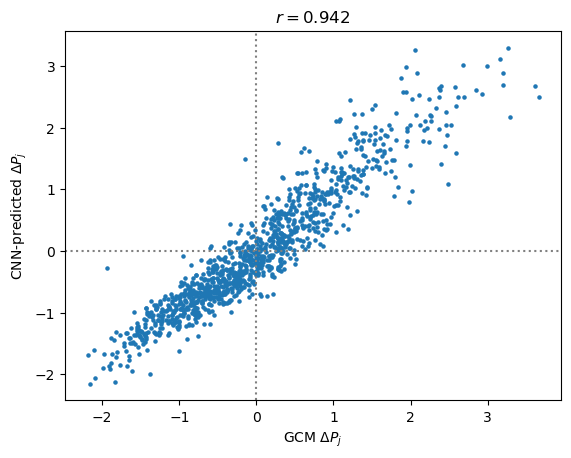

In [46]:
# CNN validation predictions
preds = model.predict(X_test)
preds = preds[:,0]
fig, ax = plt.subplots(1, 1)

Y_test_scaler = StandardScaler()
Y_test = Y_test_scaler.fit_transform(Y_test)

preds_scaler = StandardScaler()
preds = preds_scaler.fit_transform(preds.reshape(-1,1))


ax.scatter(Y_test, preds, s=5)
ax.set_xlabel('GCM $\Delta P_j$')
ax.set_ylabel('CNN-predicted $\Delta P_j$')
ax.set_title('$r=0.942$')
ax.axvline(x = 0, color = 'grey', label = 'y-axis', ls=':')
ax.axhline(y = 0, color = 'grey', label = 'x-axis', ls=':')
ax.set_axisbelow(True)
plt.savefig('CNN_correlation_plot.pdf')

In [15]:
r = np.corrcoef(Y_test.flatten(), preds)[0,1]
print(r)

0.9424733772054464


In [25]:
#residuals = Y_test.flatten() - preds
#residuals

In [26]:
#fig, ax = plt.subplots(1, 1)
#ax.hist(residuals, bins=20)
#ax.set_title('residuals plot')
#ax.set_ylabel('count')
#plt.show()

In [27]:
lat_filename = str(precip_lat).replace(".","")
lon_filename = str(precip_lon).replace(".","")
gto_filepath = "GTO_data_10deg/GTO_lat{}_lon{}.nc".format(lat_filename, lon_filename)
G = xr.open_dataarray(gto_filepath)

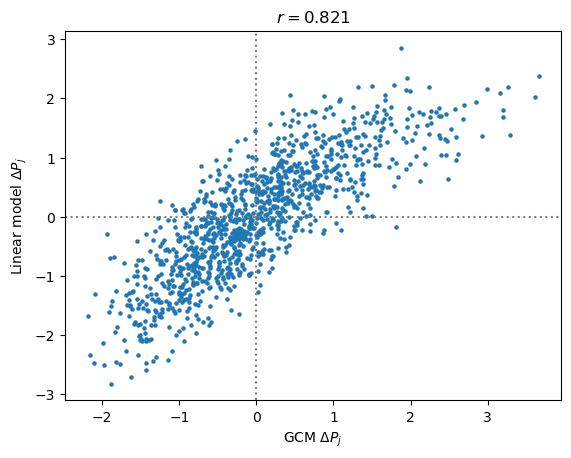

In [45]:
# test_set predictions
test_array = delta_SST.sel(idx = slice(int(0.8*num_examples), None))
weights = np.cos(np.deg2rad(G.lat))* 6371**2 * 1 * 1 * (np.pi/180)**2 * G
product = test_array.weighted(weights.fillna(0))
prediction = product.sum(('lon', 'lat'), skipna=True)

label = delta_precip.sel(time_avg='ANNUAL', lat=precip_lat, lon=precip_lon, idx = slice(int(0.8*num_examples), None))

label_scaler = StandardScaler()
preds_scaler = StandardScaler()
label = label_scaler.fit_transform(label.values.reshape(-1,1))
prediction = preds_scaler.fit_transform(prediction.values.reshape(-1,1))


fig, ax = plt.subplots(1, 1)
ax.scatter(label, prediction, s=5)
ax.set_xlabel('GCM $\Delta P_j$')
ax.set_ylabel('Linear model $\Delta P_j$')
ax.set_title('$r=0.821$')
ax.axvline(x = 0, color = 'grey', label = 'y-axis', ls=':')
ax.axhline(y = 0, color = 'grey', label = 'x-axis', ls=':')
ax.set_axisbelow(True)
plt.savefig('linear_correlation_plot.pdf')

In [20]:
r = np.corrcoef(label, prediction)[0,1]
print(r)

0.8214934249993553


The CNN model does better on the validation set than the linear model!

### Reconstruction

The first step is to get the observed delta_SST data. This is done by regridding the hadsst data onto the grid used for the random perturbation simulations, and then subtracting off the (weighted) annual mean for each year.

In [3]:
model = tf.keras.models.load_model('CNN_models/Lat5Lon175/32_16_masked.h5')

2023-03-08 13:40:55.621362: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-08 13:40:55.621427: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-08 13:40:55.621474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (host595.jc.rl.ac.uk): /proc/driver/nvidia/version does not exist
2023-03-08 13:40:55.622078: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Sandbox testing space

In [5]:
hadsst_annual_mean = xr.open_dataarray("CNN_models/hadsst_annual_SSTgrid.nc").sel(lat=slice(60, -60)) 

In [42]:
#diff = hadsst_annual_mean - hadsst_annual_mean.sel(time=slice('1980', '1999')).mean('time')

In [21]:
#subtract zonal mean for each year

diff = hadsst_annual_mean - hadsst_annual_mean.where(hadsst_annual_mean != 0, other = np.nan).mean('lon')

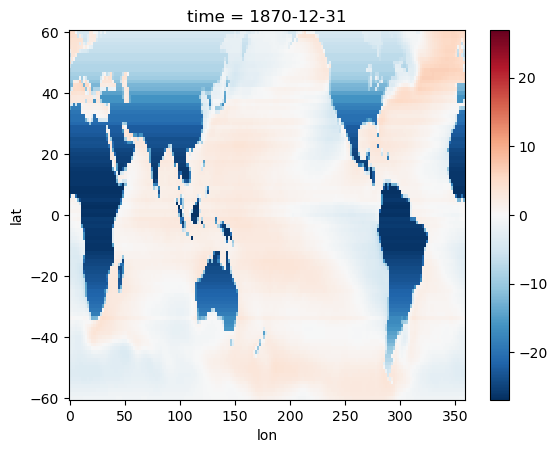

In [22]:
diff[0].plot()

##### Subtracting global annual mean SST to obtain baseline

In [67]:
weights = np.cos(np.deg2rad(hadsst_annual_mean.lat))
weights.name = "weights"
hadsst_annual_mean_weighted = hadsst_annual_mean.weighted(weights)
sst_bar = hadsst_annual_mean_weighted.mean(("lon", "lat"))

In [28]:
test = hadsst_annual_mean - sst_bar

In [11]:
sst_test = test.to_numpy()
sst_test = sst_test[..., np.newaxis]

##### Subtracting zonal annual mean SST to obtain baseline

##### Subtracting mean SST grid from 1980-99 to obtain baseline

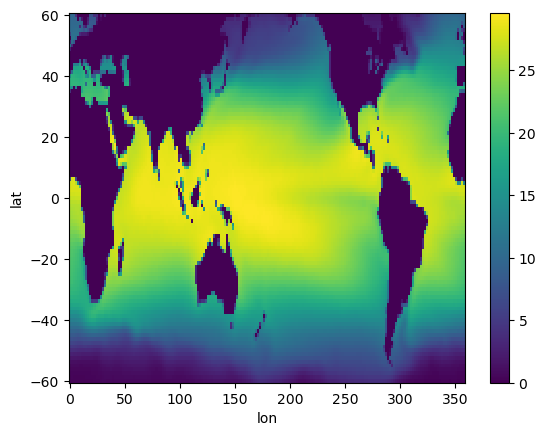

In [36]:
sst_bar = hadsst_annual_mean.sel(lat=slice(60, -60), time=slice('1980', '1999')).mean('time')
sst_bar.plot()

In [34]:
annual_mean = hadsst_annual_mean.sel(lat=slice(60, -60)).to_numpy()
annual_mean.shape

(149, 97, 192)

In [36]:
observed_delta_sst = annual_mean - sst_bar
observed_delta_sst = observed_delta_sst[..., np.newaxis]
#np.save('CNN_models/observed_delta_SST', observed_delta_sst)

In [37]:
observed_delta_sst.shape

(149, 97, 192, 1)

In [39]:
#np.save('CNN_models/observed_delta_SST_1980-99.npy', observed_delta_sst)

#### Actually loading in the observed delta_SSTs and making predictions

In [4]:
observed_delta_sst = np.load('CNN_models/observed_delta_SST_1980-99.npy')

In [62]:
deltaP_predicted = model.predict(observed_delta_sst).flatten()[121:142]
#deltaP_predicted = model.predict(observed_delta_sst).flatten()[31:142]
deltaP_predicted.shape #select predictions for years 1900 to 2010

5/5 [==============================] - 0s 56ms/step


(21,)

### Compare with ERA-20C dataset

We've just worked out our model's predictions, $\Delta P_{model}$. We also have reanalysis data, $P_{tot} = P_{0} + \Delta P_{reanalysis}$, where ${P}_{0}$ is a constant precipitation value. To scale our model's predictions to be physically interpretable, we can fit a relationship

$$ \Delta P_{model} = \alpha (P_{tot} - \tilde{P}_{0}) $$

where $\alpha$ and $\tilde{P}_{0}$ are found by regression. Then,

$$ \Delta P_{reanalysis, scaled} = \alpha (P_{tot} - \tilde{P}_{0}) $$

In [63]:
# ERA-20C reconstruction dataset, Ptot
observed_precip = xr.open_dataarray("observed_mean_annual.nc").compute()
P_tot = observed_precip.sel(lat=precip_lat, lon=precip_lon).values
P_tot = P_tot[-21:]
P_tot.shape

(21,)

In [64]:
alpha, beta, r, p, se = stats.linregress(deltaP_predicted, P_tot)
print(alpha, beta, r)
P_predicted = alpha * deltaP_predicted + beta

0.0006413375251195016 0.0077330575896020215 0.5664686164373174


Text(0.5, 1.0, 'r=0.566')

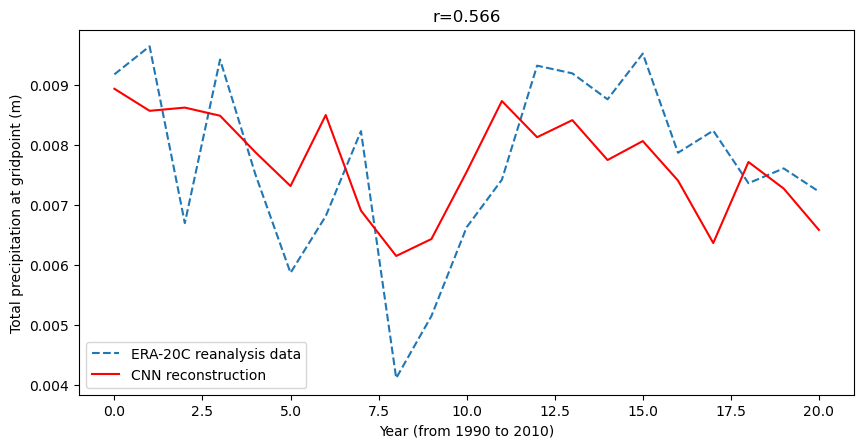

In [65]:
fig, ax = plt.subplots(figsize=(10,5))
plt.subplots_adjust(bottom=0.15)
ax.plot(P_tot, label='ERA-20C reanalysis data', linestyle='dashed')
ax.plot(P_predicted, label='CNN reconstruction', color='red')
ax.set_ylabel('Total precipitation at gridpoint (m)')
ax.set_xlabel('Year (from 1990 to 2010)')
ax.legend()
ax.set_title('r={}'.format(round(r,3)))

In [16]:
hadsst_annual_mean.time

<xarray.DataArray 'time' (time: 149)>
array(['1870-12-31T00:00:00.000000000', '1871-12-31T00:00:00.000000000',
       '1872-12-31T00:00:00.000000000', '1873-12-31T00:00:00.000000000',
       '1874-12-31T00:00:00.000000000', '1875-12-31T00:00:00.000000000',
       '1876-12-31T00:00:00.000000000', '1877-12-31T00:00:00.000000000',
       '1878-12-31T00:00:00.000000000', '1879-12-31T00:00:00.000000000',
       '1880-12-31T00:00:00.000000000', '1881-12-31T00:00:00.000000000',
       '1882-12-31T00:00:00.000000000', '1883-12-31T00:00:00.000000000',
       '1884-12-31T00:00:00.000000000', '1885-12-31T00:00:00.000000000',
       '1886-12-31T00:00:00.000000000', '1887-12-31T00:00:00.000000000',
       '1888-12-31T00:00:00.000000000', '1889-12-31T00:00:00.000000000',
       '1890-12-31T00:00:00.000000000', '1891-12-31T00:00:00.000000000',
       '1892-12-31T00:00:00.000000000', '1893-12-31T00:00:00.000000000',
       '1894-12-31T00:00:00.000000000', '1895-12-31T00:00:00.000000000',
       '1896-12-31T00:00:00.000000000', '1897-12-31T00:00:00.000000000',
       '1898-12-31T00:00:00.000000000', '1899-12-31T00:00:00.000000000',
       '1900-12-31T00:00:00.000000000', '1901-12-31T00:00:00.000000000',
       '1902-12-31T00:00:00.000000000', '1903-12-31T00:00:00.000000000',
       '1904-12-31T00:00:00.000000000', '1905-12-31T00:00:00.000000000',
       '1906-12-31T00:00:00.000000000', '1907-12-31T00:00:00.000000000',
       '1908-12-31T00:00:00.000000000', '1909-12-31T00:00:00.000000000',
       '1910-12-31T00:00:00.000000000', '1911-12-31T00:00:00.000000000',
       '1912-12-31T00:00:00.000000000', '1913-12-31T00:00:00.000000000',
       '1914-12-31T00:00:00.000000000', '1915-12-31T00:00:00.000000000',
       '1916-12-31T00:00:00.000000000', '1917-12-31T00:00:00.000000000',
       '1918-12-31T00:00:00.000000000', '1919-12-31T00:00:00.000000000',
       '1920-12-31T00:00:00.000000000', '1921-12-31T00:00:00.000000000',
       '1922-12-31T00:00:00.000000000', '1923-12-31T00:00:00.000000000',
       '1924-12-31T00:00:00.000000000', '1925-12-31T00:00:00.000000000',
       '1926-12-31T00:00:00.000000000', '1927-12-31T00:00:00.000000000',
       '1928-12-31T00:00:00.000000000', '1929-12-31T00:00:00.000000000',
       '1930-12-31T00:00:00.000000000', '1931-12-31T00:00:00.000000000',
       '1932-12-31T00:00:00.000000000', '1933-12-31T00:00:00.000000000',
       '1934-12-31T00:00:00.000000000', '1935-12-31T00:00:00.000000000',
       '1936-12-31T00:00:00.000000000', '1937-12-31T00:00:00.000000000',
       '1938-12-31T00:00:00.000000000', '1939-12-31T00:00:00.000000000',
       '1940-12-31T00:00:00.000000000', '1941-12-31T00:00:00.000000000',
       '1942-12-31T00:00:00.000000000', '1943-12-31T00:00:00.000000000',
       '1944-12-31T00:00:00.000000000', '1945-12-31T00:00:00.000000000',
       '1946-12-31T00:00:00.000000000', '1947-12-31T00:00:00.000000000',
       '1948-12-31T00:00:00.000000000', '1949-12-31T00:00:00.000000000',
       '1950-12-31T00:00:00.000000000', '1951-12-31T00:00:00.000000000',
       '1952-12-31T00:00:00.000000000', '1953-12-31T00:00:00.000000000',
       '1954-12-31T00:00:00.000000000', '1955-12-31T00:00:00.000000000',
       '1956-12-31T00:00:00.000000000', '1957-12-31T00:00:00.000000000',
       '1958-12-31T00:00:00.000000000', '1959-12-31T00:00:00.000000000',
       '1960-12-31T00:00:00.000000000', '1961-12-31T00:00:00.000000000',
       '1962-12-31T00:00:00.000000000', '1963-12-31T00:00:00.000000000',
       '1964-12-31T00:00:00.000000000', '1965-12-31T00:00:00.000000000',
       '1966-12-31T00:00:00.000000000', '1967-12-31T00:00:00.000000000',
       '1968-12-31T00:00:00.000000000', '1969-12-31T00:00:00.000000000',
       '1970-12-31T00:00:00.000000000', '1971-12-31T00:00:00.000000000',
       '1972-12-31T00:00:00.000000000', '1973-12-31T00:00:00.000000000',
       '1974-12-31T00:00:00.000000000', '1975-12-31T00:00:00.000000000',
       '1976-12-31T00:00:00.000000000', '1977-12-31T00:00:00.000000000',
       '1978-12-31T0

In [50]:
test = xr.open_dataarray('CNN_models/observed_delta_SST_1980-99.nc')

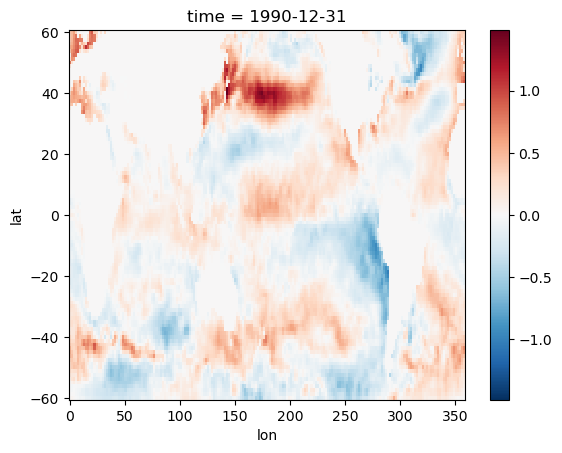

In [40]:
test.sel(time='1990').plot()

In [21]:
test_gto = xr.open_dataarray('GTO_piecewise_10deg/GTO_neg_lat-150_lon1050.nc')
test_gto

<xarray.DataArray (lat: 145, lon: 192)>
[27840 values with dtype=float64]
Coordinates:
  * lat      (lat) float32 90.0 88.75 87.5 86.25 ... -86.25 -87.5 -88.75 -90.0
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1

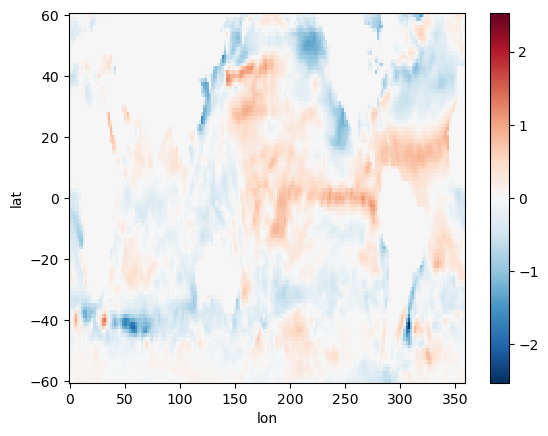

In [50]:
xr.DataArray(observed_delta_sst[-50,...,0], dims=['lat', 'lon'], coords={'lat':np.linspace(60,-60,97), 'lon':np.linspace(0, 358.1, 192)}).plot()